## Fazendo a integração com o conjunto de dados do Kaggle

In [ ]:
# Faz upload do arquivo "kaggle.json" com API Token do perfil do usuário
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
# Testa se upload foi feito com sucesso
!ls

kaggle.json  sample_data


In [ ]:
# Move arquivo para a uma pasta e dá permissões ao sistema
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Fazendo download do dataset
! kaggle datasets download -d ealaxi/paysim1

 97% 172M/178M [00:01<00:00, 105MB/s]
100% 178M/178M [00:01<00:00, 118MB/s]


In [ ]:
# Conferindo o download
!ls

kaggle.json  paysim1.zip  sample_data


## Construindo o modelo dos dados na memória

In [ ]:
import zipfile
import pandas as pd
 
# Cria dataframe do pandas a partir do zip
df = pd.read_csv('paysim1.zip',compression='zip')
 
# Exibindo o começo do dataframe
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
df_to_change = df.copy()

# Removendo as colunas inúteis
df_to_change = df_to_change.drop(labels=["isFlaggedFraud", "newbalanceDest", "newbalanceOrig", "nameDest", "nameOrig"], axis=1)

# Informando que isFraud é booleano
df_to_change["isFraud"] = df_to_change["isFraud"].astype("bool")
df_to_change["type"] = df_to_change["type"].astype("string")

df_to_change.head()

,step,type,amount,oldbalanceOrg,oldbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,0.0,False
1,1,PAYMENT,1864.28,21249.0,0.0,False
2,1,TRANSFER,181.00,181.0,0.0,True
3,1,CASH_OUT,181.00,181.0,21182.0,True
4,1,PAYMENT,11668.14,41554.0,0.0,False


In [ ]:
df_to_change.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            string 
 2   amount          float64
 3   oldbalanceOrg   float64
 4   oldbalanceDest  float64
 5   isFraud         bool   
dtypes: bool(1), float64(3), int64(1), string(1)
memory usage: 248.8 MB


In [ ]:
# Só é permitido dados númericos, então será feito tratamento
# 1 PAYMENT, 2 TRANSFER, 3 CASH_OUT, 4 DEBIT, 5 CASH_IN
tipos_transacoes = []

for tipo in df_to_change.type:
  if tipo not in tipos_transacoes:
    tipos_transacoes.append(tipo)

print(tipos_transacoes)

['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN']


In [ ]:
df_to_change.type = df_to_change.type.map({'PAYMENT': 1, 'TRANSFER': 2, 'CASH_OUT': 3, 'DEBIT': 4, 'CASH_IN': 5})
df_to_change.head()

,step,type,amount,oldbalanceOrg,oldbalanceDest,isFraud
0,1,1,9839.64,170136.0,0.0,False
1,1,1,1864.28,21249.0,0.0,False
2,1,2,181.00,181.0,0.0,True
3,1,3,181.00,181.0,21182.0,True
4,1,1,11668.14,41554.0,0.0,False


# Construindo a Árvore de Decisão

Bibliotecas utilizadas

In [ ]:
from sklearn import tree
import pandas as pd
from sklearn.model_selection import train_test_split
import graphviz
import matplotlib.pyplot as plt
import numpy as np

Separação dos dados entre suas características e sua classificação.

In [ ]:
class_y = pd.DataFrame(df_to_change.isFraud, columns=["isFraud"])
class_y.isFraud = class_y.isFraud.map({False: 0, True: 1})
features_x = df_to_change.drop(["isFraud"], axis=1) 

features_x.head()

,step,type,amount,oldbalanceOrg,oldbalanceDest
0,1,1,9839.64,170136.0,0.0
1,1,1,1864.28,21249.0,0.0
2,1,2,181.00,181.0,0.0
3,1,3,181.00,181.0,21182.0
4,1,1,11668.14,41554.0,0.0


In [ ]:
class_y.head()

,isFraud
0,0
1,0
2,1
3,1
4,0


Separando os dados entre treinamento e teste

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_x, class_y, test_size=0.33, random_state=42)

*Treinando o classificador*

In [ ]:
# Adicionei max_depth=15 porque ele é responsável por diminuir o overfit. Possivelmente isso vai diminuir a acurácia do conjunto de treinamento.
decion_tree = tree.DecisionTreeClassifier(min_samples_split=20, random_state=99, max_depth=15)
decion_tree = decion_tree.fit(X_train, y_train)

Acurácia

In [ ]:
print("Acurácia do conjunto de treinamento: {:.3f}".format(decion_tree.score(X_train, y_train)))
print("Acurácia do conjunto de teste: {:.3f}".format(decion_tree.score(X_test, y_test)))

Acurácia do conjunto de treinamento: 1.000
Acurácia do conjunto de teste: 0.999


Árvore de Decisão Treinada

* Como dito o arquivo é muito grande, mas caso queira ver, basta olhar nos arquivos gerados na execução, lá terá um arquivo de nome Source.gv.png.

In [ ]:
tree.export_graphviz(decion_tree, out_file="arvore.dot", class_names=['0', '1'], feature_names=features_x.columns.tolist(), impurity=False, filled=True)

with open("arvore.dot") as f:
  dot_graph = f.read()
  img = graphviz.Source(dot_graph, format='png')
  img.view()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.643828 to fit


Verificando as features importantes para decisão

In [ ]:
print("Feature importances:\n{}".format(decion_tree.feature_importances_))

Feature importances:
[0.16403672 0.09022276 0.20998978 0.37983428 0.15591647]


Text(0, 0.5, 'Feature')

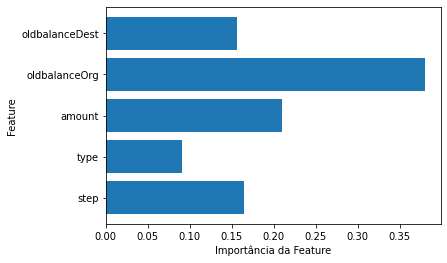

In [ ]:
numero_features = features_x.shape[1]
plt.barh(range(numero_features), decion_tree.feature_importances_, align='center')
plt.yticks(np.arange(numero_features), features_x.columns.tolist())
plt.xlabel("Importância da Feature")
plt.ylabel("Feature")